# Modules

In [8]:
import timm
from fastai.vision.all import *
from fastai.vision.widgets import *
import os

os.environ["TORCH_HOME"] = "/media/hdd/Datasets/"
os.environ["FASTAI_HOME"] = "/media/hdd/Datasets/"

# Data

In [30]:
root_dir = "/media/hdd/Datasets/Pets/images/"
path = Path(root_dir)
fields = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=lambda x: x.name.split("_")[0],
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=RandomResizedCrop(64, min_scale=0.5),
    batch_tfms=aug_transforms(),
)
dls = fields.dataloaders(path)

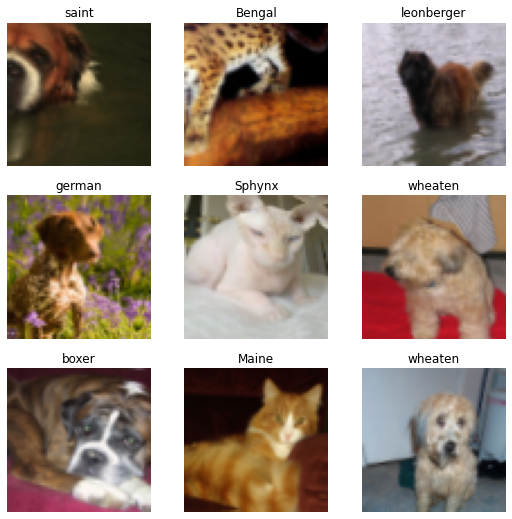

In [31]:
dls.show_batch()

In [32]:
dls.c

35

# Model

## To change
- **Search for #new**
- Stage compute ratio (x)
- Patchify
- Inverted Bottleneck
- Large Kernel Size
    - Depthwise conv
    - Replace 3x3 with 7x7 (x)
- RelU with GELU (x)
- fewer activation fns (x)
- fewer normalization layers (x)
- bn with ln
- separate downsampling layers

In [223]:
from collections import OrderedDict

In [224]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding = (
            self.kernel_size[0] // 2,
            self.kernel_size[1] // 2,
        )  # dynamic add padding based on the kernel_size


conv3x3 = partial(Conv2dAuto, kernel_size=7, bias=False)  # new- > ks = 7

In [225]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels = in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()

    def forward(self, x):
        residual = x
        if self.should_apply_shortcut:
            residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x

    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

In [226]:
class ResNetResidualBlock(ResidualBlock):
    def __init__(
        self,
        in_channels,
        out_channels,
        expansion=1,
        downsampling=1,
        conv=conv3x3,
        *args,
        **kwargs
    ):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = (
            nn.Sequential(
                OrderedDict(
                    {
                        "conv": nn.Conv2d(
                            self.in_channels,
                            self.expanded_channels,
                            kernel_size=1,
                            stride=self.downsampling,
                            bias=False,
                        ),
                        "bn": nn.BatchNorm2d(self.expanded_channels),
                    }
                )
            )
            if self.should_apply_shortcut
            else None
        )

    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion

    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels


def conv_bn(in_channels, out_channels, conv, supress_bn=False, *args, **kwargs):
    if supress_bn == False:
        return nn.Sequential(
            OrderedDict(
                {
                    "conv": conv(in_channels, out_channels, *args, **kwargs),
                    "bn": nn.BatchNorm2d(out_channels),
                }
            )
        )
    else:
        # new -> option to just have bn. Not replacing the code for consistency
        return nn.Sequential(
            OrderedDict(
                {
                    "conv": conv(in_channels, out_channels, *args, **kwargs),
                }
            )
        )

In [227]:
class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1

    def __init__(
        self,
        in_channels,
        out_channels,
        #                  activation=nn.ReLU,
        activation=nn.GELU,  # new
        *args,
        **kwargs
    ):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(
                self.in_channels,
                self.out_channels,
                conv=self.conv,
                bias=False,
                stride=self.downsampling,
            ),
            activation(),
            conv_bn(
                self.out_channels, self.expanded_channels, conv=self.conv, bias=False
            ),
        )

In [228]:
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4

    def __init__(
        self,
        in_channels,
        out_channels,
        #                  activation=nn.ReLU,
        activation=nn.GELU,  # new
        *args,
        **kwargs
    ):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(
                self.in_channels,
                self.out_channels,
                self.conv,
                kernel_size=1,
                supress_bn=True,
            ),  # new -> remove batch norm
            #             activation(), #new -> remove activation
            conv_bn(
                self.out_channels,
                self.out_channels,
                self.conv,
                kernel_size=7,
                stride=self.downsampling,
                supress_bn=True,
            ),  # new -> remove batch norm , ks = 7
            activation(),
            conv_bn(
                self.out_channels, self.expanded_channels, self.conv, kernel_size=1
            ),
        )

In [229]:
class ResNetLayer(nn.Module):
    def __init__(
        self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs
    ):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1

        self.blocks = nn.Sequential(
            block(
                in_channels, out_channels, *args, **kwargs, downsampling=downsampling
            ),
            *[
                block(
                    out_channels * block.expansion,
                    out_channels,
                    downsampling=1,
                    *args,
                    **kwargs
                )
                for _ in range(n - 1)
            ]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

In [230]:
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """

    def __init__(
        self,
        in_channels=3,
        blocks_sizes=[64, 128, 256, 512],
        deepths=[2, 2, 2, 2],
        #                  activation=nn.ReLU,
        activation=nn.GELU,  # new
        block=ResNetBasicBlock,
        *args,
        **kwargs
    ):
        super().__init__()

        self.blocks_sizes = blocks_sizes

        self.gate = nn.Sequential(
            nn.Conv2d(
                in_channels,
                self.blocks_sizes[0],
                kernel_size=7,
                stride=2,
                padding=3,
                bias=False,
            ),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=7, stride=2, padding=1),
        )

        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList(
            [
                ResNetLayer(
                    blocks_sizes[0],
                    blocks_sizes[0],
                    n=deepths[0],
                    activation=activation,
                    block=block,
                    *args,
                    **kwargs
                ),
                *[
                    ResNetLayer(
                        in_channels * block.expansion,
                        out_channels,
                        n=n,
                        activation=activation,
                        block=block,
                        *args,
                        **kwargs
                    )
                    for (in_channels, out_channels), n in zip(
                        self.in_out_block_sizes, deepths[1:]
                    )
                ],
            ]
        )

    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

In [231]:
class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """

    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

In [232]:
class ResNet(nn.Module):
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(
            self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


def resnet50_custom(n_classes):
    return ResNet(3, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 6, 3])


def convnext(n_classes):
    return ResNet(
        3, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 3, 9, 3]
    )  # new -> block order

# Training Tricks

- AdamW (x)
    - lr: 4e-4 , 20 epoch linear warmup , cosine decaying, weight decay of 0.05
- Mixup (x)
- CutMix (error)
- RandAugment
- RandomErasing (x)
- Stocashtic Depth (https://github.com/shamangary/Pytorch-Stochastic-Depth-Resnet/blob/master/TYY_stodepth_lineardecay.py)
- Label Smoothing (x)

In [233]:
learn = Learner(
    dls,
    convnext(dls.c),
    loss_func=LabelSmoothingCrossEntropy(),
    opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
    metrics=[accuracy, error_rate],
    cbs=[MixUp, RandomErasing],
).to_fp16()

In [234]:
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, MixedPrecision, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, MixUp, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [MixUp, CastToTensor, MixedPrecision]
         - after_pred     : [MixedPrecision]
         - after_loss     : [MixedPrecision]
         - before_backward: [MixedPrecision]
         - before_step    : [MixedPrecision]
         - after_step     : [MixedPrecision]
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [MixUp, Recorder]
     - after_train    : [MixUp, Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch

In [235]:
learn.fit_flat_cos(20, wd=0.05, lr=4e-3)  # new -> flat warmup before cosine

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.546743,3.507943,0.067659,0.932341,00:14


KeyboardInterrupt: 

In [54]:
learn.fit_one_cycle(300, wd=0.05)  # new -> weight decay and no of epochs

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.681692,3.752759,0.039242,0.960758,00:09
1,3.670112,3.734652,0.043302,0.956698,00:09
2,3.652822,3.691226,0.039919,0.960081,00:09
3,3.635180,3.673675,0.043978,0.956022,00:10


KeyboardInterrupt: 